In [50]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pathlib
data_dir = pathlib.Path("./data")
print(data_dir)

data


In [4]:
img_height,img_width=200,200
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2726 files belonging to 2 classes.
Using 2181 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2726 files belonging to 2 classes.
Using 545 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['autistic', 'non_autistic']


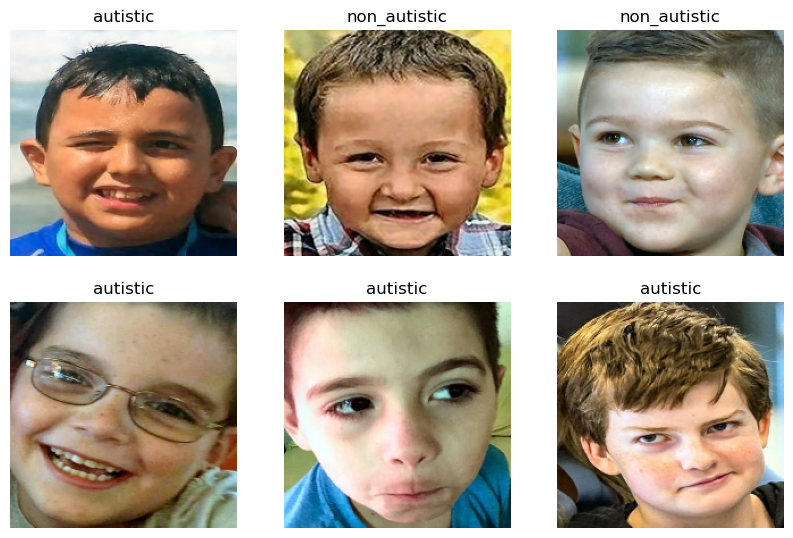

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(200,200,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False
        
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(2, activation='sigmoid'))

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 64)               131136    
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 2)                130       
 pper)                                                           
                                                                 
Total params: 23,718,978
Trainable params: 131,266
Non-trainable params: 23,587,712
______________________________________

In [10]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

C:\Users\ironicinno\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

In [12]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
69/69 [==============================] - 24s 207ms/step - loss: 0.5680 - accuracy: 0.6992 - val_loss: 0.4710 - val_accuracy: 0.7688
Epoch 2/10
69/69 [==============================] - 12s 177ms/step - loss: 0.4515 - accuracy: 0.7932 - val_loss: 0.5292 - val_accuracy: 0.7358
Epoch 3/10
69/69 [==============================] - 12s 177ms/step - loss: 0.4146 - accuracy: 0.8111 - val_loss: 0.4467 - val_accuracy: 0.8073
Epoch 4/10
69/69 [==============================] - 12s 178ms/step - loss: 0.3690 - accuracy: 0.8271 - val_loss: 0.4760 - val_accuracy: 0.7725
Epoch 5/10
69/69 [==============================] - 12s 178ms/step - loss: 0.3516 - accuracy: 0.8469 - val_loss: 0.4018 - val_accuracy: 0.8128
Epoch 6/10
69/69 [==============================] - 13s 180ms/step - loss: 0.3128 - accuracy: 0.8748 - val_loss: 0.3930 - val_accuracy: 0.8128
Epoch 7/10
69/69 [==============================] - 12s 179ms/step - loss: 0.3009 - accuracy: 0.8730 - val_loss: 0.4171 - val_accuracy: 0.8275

In [66]:
test_data_dir = pathlib.Path("./test")

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 200 files belonging to 2 classes.


In [67]:
loss, accuracy = resnet_model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

18/18 [==============================] - 3s 130ms/step - loss: 0.3924 - accuracy: 0.8239
Validation Loss: 0.3923536539077759
Validation Accuracy: 0.8238531947135925


In [68]:
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
test_loss, test_accuracy = resnet_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 1s 120ms/step - loss: 0.3267 - accuracy: 0.8600
Test Loss: 0.32670366764068604
Test Accuracy: 0.8600000143051147


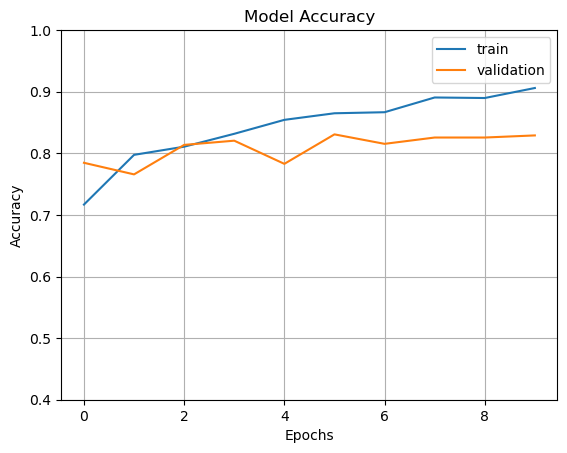

In [13]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

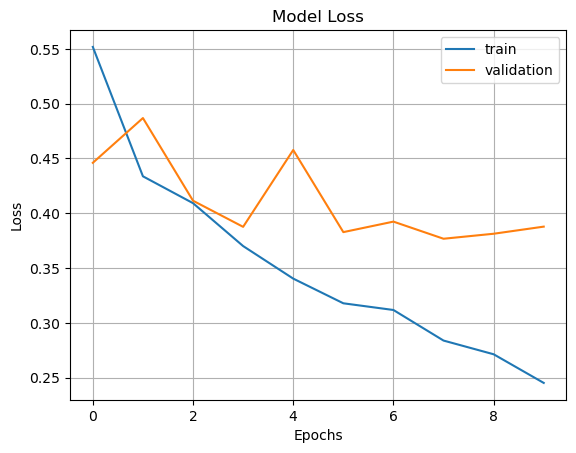

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

data\autistic\0003.jpg


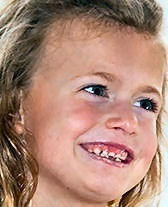

In [13]:
data_autistic = list(data_dir.glob('autistic/*'))
print(data_autistic[2])
PIL.Image.open(str(data_autistic[2]))

In [14]:
import cv2
image=cv2.imread(str(data_autistic[3]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 200, 200, 3)


In [39]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 0s 24ms/step
[[0.77365494 0.21859632]]


In [43]:
image_autistic_prob = pred[0][0]
image_non_autistic_prob = pred[0][1]
image_autistic_prob

0.77365494

In [16]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is autistic


In [69]:
# test_dir = pathlib.Path("./random")
# print(test_dir)

In [70]:
# num = 4
# test_dir_inside = list(test_dir.glob('non/*'))
# print(test_dir_inside[num])
# PIL.Image.open(str(test_dir_inside[num]))

In [71]:
# import cv2
# image2=cv2.imread(str(test_dir_inside[num]))
# image2_resized= cv2.resize(image2, (img_height,img_width))
# image2=np.expand_dims(image2_resized,axis=0)
# print(image2.shape)

In [72]:
# pred=resnet_model.predict(image2)
# print(pred)

In [73]:
# output_class=class_names[np.argmax(pred)]
# print("The predicted class is", output_class)

In [27]:
# Save the model
# resnet_model.save("my_resnet1")

INFO:tensorflow:Assets written to: my_resnet1\assets


INFO:tensorflow:Assets written to: my_resnet1\assets


In [31]:
import pandas as pd
df = pd.read_csv('data.csv')
df

,Questions,1,2,3,4,5,child_1
0,1- Does your child look at you when you call t...,Always,Usually,Sometimes,Rarely,Never,3
1,2- How easy is it for you to make eye contact ...,Very easy,Quite easy,Quite difficult,Very difficult,Impossible,4
2,3- Does your child point to indicate that they...,Many times a day,Several times a day,Several times a week,Less than once a week,Never,3
3,4- Does your child point to share an interest ...,Many times a day,Several times a day,Several times a week,Less than once a week,Never,1
4,5- Does your child engage in pretend play? (e....,Many times a day,Several times a day,Several times a week,Less than once a week,Never,1
5,6- Does your child follow your gaze?,Many times a day,Several times a day,Several times a week,Less than once a week,Never,2
6,7- If you or someone in your family is visibly...,Always,Usually,Sometimes,Rarely,Never,5
7,8- Would you describe your child's first words...,Very common,Quite common,Slightly uncommon,Very uncommon,My child does not speak,2
8,"9- Does your child use simple gestures? (e.g.,...",Many times a day,Several times a day,Several times a week,Less than once a week,Never,2
9,10- Does your child stare at nothing for no ap...,Less than once a week,Never,Several times a week,Several times a day,Many times a day,4


In [32]:
df['score'] = 0

for index, row in df.iterrows():
    if row['child_1'] > 2:
        df.at[index, 'score'] = 1

df

,Questions,1,2,3,4,5,child_1,score
0,1- Does your child look at you when you call t...,Always,Usually,Sometimes,Rarely,Never,3,1
1,2- How easy is it for you to make eye contact ...,Very easy,Quite easy,Quite difficult,Very difficult,Impossible,4,1
2,3- Does your child point to indicate that they...,Many times a day,Several times a day,Several times a week,Less than once a week,Never,3,1
3,4- Does your child point to share an interest ...,Many times a day,Several times a day,Several times a week,Less than once a week,Never,1,0
4,5- Does your child engage in pretend play? (e....,Many times a day,Several times a day,Several times a week,Less than once a week,Never,1,0
5,6- Does your child follow your gaze?,Many times a day,Several times a day,Several times a week,Less than once a week,Never,2,0
6,7- If you or someone in your family is visibly...,Always,Usually,Sometimes,Rarely,Never,5,1
7,8- Would you describe your child's first words...,Very common,Quite common,Slightly uncommon,Very uncommon,My child does not speak,2,0
8,"9- Does your child use simple gestures? (e.g.,...",Many times a day,Several times a day,Several times a week,Less than once a week,Never,2,0
9,10- Does your child stare at nothing for no ap...,Less than once a week,Never,Several times a week,Several times a day,Many times a day,4,1


In [33]:
total_score = df['score'].sum()
total_score

5

In [45]:
def divide_probability(score):
    if score >= 3:
        probability = (score - 3) / 7 * 0.5 + 0.5
    else:
        probability = score / 3 * 0.5
    return probability

score_autistic_prob = divide_probability(total_score)
score_non_autistic_prob = 1 - score_autistic_prob
score_autistic_prob

0.6428571428571428

In [46]:
total_autistic = image_autistic_prob + score_autistic_prob
total_autistic = total_autistic / 2
total_non_autistic = image_non_autistic_prob + score_non_autistic_prob
total_non_autistic = total_non_autistic / 2

In [42]:
print(f"Combined Autistic Prob: {total_autistic}, Combined Non Autistic Prob: {total_non_autistic}")

Combined Autistic Prob: 0.7082560403006417, Combined Non Autistic Prob: 0.2878695907337325
